In [1]:
import sklearn
from sklearn.datasets import fetch_covtype
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 200
LARGE_VAL = 10000000
ITER_THRESH = 5

In [2]:
#A function to get the 20 newsgroup data
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    cov = fetch_covtype()
    all_data = np.array(cov.data)
    all_targets = np.array(cov.target)
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = [1, 2, 3]
    view2_classes = [4, 5, 6]
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 200 items from each of the selected classes in view2
    for class_num in view2_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = np.vstack(view1_data)
    view2_data = np.vstack(view2_data)
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    magnitudes1 = np.linalg.norm(view1_data, axis=0)
    magnitudes2 = np.linalg.norm(view2_data, axis=0)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((1, -1))
    magnitudes2 = magnitudes2.reshape((1, -1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    return view1_data, view2_data, labels


In [3]:
v1_data, v2_data, labels = get_data()

In [4]:
#Function to initialize partitions
def compute_distances(data, c_centers, k): 
    distances = list()
    for cl in range(k):
        dist = data - c_centers[cl]
        dist = np.linalg.norm(dist, axis = 1)
        distances.append(dist)
    distances = np.vstack(distances)
    return distances

#A function to compute the value of the objective function
def compute_objective(data, c_centers, partitions):

    o_funct = 0
    for clust in range(c_centers.shape[0]):
        vecs = data[(partitions == clust)]
        dist = np.linalg.norm(vecs - c_centers[clust], axis=1)
        o_funct += np.sum(dist)
        
    return o_funct


#A function to run through a single iteration of maximization and expectation
#(in that order)
def iterate_clusters(data, partitions, k):

    #Recompute cluster centers
    new_centers = list()
    for clust in range(k):
        vec = np.mean(data[(partitions == clust)], axis = 0)
        new_centers.append(vec)
    new_centers = np.vstack(new_centers)
        
    #Assign each sample point to a partition
    distances = compute_distances(data, new_centers, k)
    new_partitions = np.argmin(distances, axis = 0).flatten()

    return new_centers, new_partitions


In [5]:
#A function to consolidate the final clusters from the two views
def final_clusters(v_data, v_partitions, c_centers, k):

    v1_consensus = list()
    v2_consensus = list()
    for clust in range(k):
        part_indices = (v_partitions[0] == clust) * (v_partitions[1] == clust)
        #View 1
        vec1 = np.mean(v_data[0][part_indices], axis = 0)
        v1_consensus.append(vec1)

        #View 2
        vec2 = np.mean(v_data[1][part_indices], axis = 0)
        v2_consensus.append(vec2)
        
    v1_consensus = np.vstack(v1_consensus)
    v2_consensus = np.vstack(v2_consensus)
        
    dist1 = compute_distances(v_data[0], v1_consensus, k)
    dist2 = compute_distances(v_data[1], v2_consensus, k)
    dist_metric = dist1 + dist2
    new_partitions = np.argmin(dist_metric,axis = 0).flatten()
    return new_partitions

In [6]:
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [7]:
#The main kmeans clustering algorithm
def kmeans(v_data, labels, k = 3):

    #Initialize cluster centers, partitions, and loop params
    indices = np.random.choice(v_data[1].shape[0], k)
    c_centers2 = v_data[1][indices]
    c_centers = [None, c_centers2]
    
    distances2 = compute_distances(v_data[1], c_centers2, k)
    partitions2 = np.argmin(distances2,axis = 0).flatten()
    
    v_partitions = [None, partitions2]
    objective = [LARGE_VAL, LARGE_VAL]
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        c_centers[view], v_partitions[view] = iterate_clusters(v_data[view], v_partitions[(view + 1) % 2], k)
        o_funct = compute_objective(v_data[view], c_centers[view], v_partitions[view])
        iter_stall += 1
        
        #Recompute objective function
        if(o_funct < objective[view]):
            objective[view] = o_funct
            iter_stall = 0
        
        
        #Obtain evaluation metrics
        f_clusters = final_clusters(v_data, v_partitions, c_centers, k)
        entropy = compute_entropy(f_clusters, labels, k, 3)

    return entropy
            

In [8]:
#ent = kmeans([v1_data, v2_data], labels, 3)

In [9]:
def getEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1, 7):
        ent = kmeans([v1_data, v2_data], labels, num)
        entropies.append(ent)
    return entropies


#Do kmeans and get entropy values for each k
num_trials = 10
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
mult_entropies = np.mean(mult_entropies, axis=0)

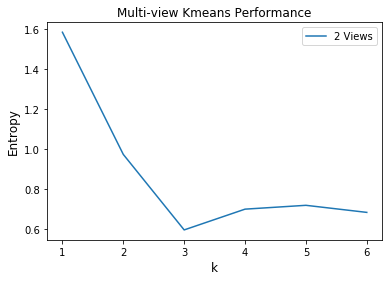

In [12]:
import matplotlib.pyplot as plt
x_values = list(range(1, 7))
plt.plot(x_values, entropies)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.title('Multi-view Kmeans Performance')
plt.rc('axes', labelsize=12)
plt.show()